# Overview

This project involves comprehensive data loading, preprocessing, and modeling for image captioning tasks. Initially, the code checks and loads datasets from CSV files for train, validation, and test sets, ensuring all files exist before proceeding. It preprocesses text data by converting captions to lowercase, removing URLs, special characters, and stop words, and applying stemming and lemmatization. Image data integrity is verified by checking for missing images using image names extracted from the training dataset, and cleaned data is saved to a CSV file. Images are preprocessed using TensorFlow, applying resizing, flipping, brightness, contrast adjustments, and normalization in batches. Text data is tokenized and padded using Tokenizer and pad_sequences, preparing it for model training. The model architecture is defined using TensorFlow/Keras, comprising image and text inputs, embedding, LSTM layers, and dense layers, optimized with Adam and evaluated with sparse categorical crossentropy loss. Training occurs over 10 epochs, monitoring training and validation loss and accuracy. The model is evaluated on validation and test datasets, and results are visualized using Matplotlib to assess model performance. Overall, the workflow ensures robust handling of data, effective preprocessing, and rigorous model training and evaluation for image caption generation.

In [31]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Define paths to CSV files for train, validation, and test sets
train_path = 'D:/Internship/archive (1)/all_data/train/radiologytraindata_no_id.csv'
val_path = 'D:/Internship/archive (1)/all_data/validation/radiologyvaldata.csv'
test_path = 'D:/Internship/archive (1)/all_data/test/radiologytestdata.csv'

# Check if all files exist and load them
datasets = {}
missing_files = []

for path in [train_path, val_path, test_path]:
    if os.path.exists(path):
        print(f"File found: {path}")
        dataset_name = os.path.basename(path).split('.')[0]
        datasets[dataset_name] = pd.read_csv(path)
        print(f"Data from {dataset_name} loaded successfully!")
    else:
        print(f"File not found: {path}")
        missing_files.append(path)

# If there are missing files, print them
if missing_files:
    print("Some files are missing. Please verify the following paths:")
    for file_path in missing_files:
        print(file_path)

# Explore the loaded data
for dataset_name, data in datasets.items():
    print(f"\n{dataset_name} Data:")
    print(data.head())
    print(f"Shape of {dataset_name}: {data.shape}")

# Load the train data
train_data = datasets.get('radiologytraindata_no_id')


File found: D:/Internship/archive (1)/all_data/train/radiologytraindata_no_id.csv
Data from radiologytraindata_no_id loaded successfully!
File found: D:/Internship/archive (1)/all_data/validation/radiologyvaldata.csv
Data from radiologyvaldata loaded successfully!
File found: D:/Internship/archive (1)/all_data/test/radiologytestdata.csv
Data from radiologytestdata loaded successfully!

radiologytraindata_no_id Data:
                                     name  \
0          PMC4083729_AMHSR-4-14-g002.jpg   
1       PMC2837471_IJD2009-150251.001.jpg   
2  PMC2505281_11999_2007_30_Fig6_HTML.jpg   
3       PMC3745845_IJD2013-683423.005.jpg   
4   PMC4917066_amjcaserep-17-301-g001.jpg   

                                             caption  
0   Computed tomography scan in axial view showin...  
1   Bacterial contamination occurred after comple...  
2   The patient had residual paralysis of the han...  
3    Panoramic radiograph after immediate loading.\n  
4   Plain abdomen x-ray: Multiple 

# Text Preprocessing

In [32]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Convert to lower case
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove links
    text = text.replace('\n', ' ')  # Remove new lines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stop words
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])  # Stemming
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # Lemmatization
    return text

# Apply preprocessing to the caption column
train_data['cleaned_caption'] = train_data['caption'].apply(preprocess_text)
print(train_data[['caption', 'cleaned_caption']].head())
print(train_data.shape)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                             caption  \
0   Computed tomography scan in axial view showin...   
1   Bacterial contamination occurred after comple...   
2   The patient had residual paralysis of the han...   
3    Panoramic radiograph after immediate loading.\n   
4   Plain abdomen x-ray: Multiple air levels at t...   

                                     cleaned_caption  
0  comput tomographi scan axial view show obliter...  
1  bacteri contamin occur complet root canal trea...  
2  patient residu paralysi hand poliomyel necessa...  
3                     panoram radiograph immedi load  
4  plain abdomen xray multipl air level midabdome...  
(65450, 3)


In [33]:
pip install tensorflow tqdm psutil


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [34]:
from tqdm import tqdm
import cv2

# Directory containing the images
image_dir = 'D:/Internship/archive (1)/all_data/train/radiology/images 66000'

# Check for missing images in the dataset
missing_images = []

for img_name in tqdm(train_data['name'], desc="Checking images"):
    img_path = os.path.join(image_dir, img_name)
    if not os.path.exists(img_path):
        missing_images.append(img_name)

# Remove rows with missing images from the DataFrame
train_data_cleaned = train_data[~train_data['name'].isin(missing_images)]
cleaned_csv_path = 'D:/Internship/archive (1)/all_data/train/radiologytraindata_cleaned.csv'
train_data_cleaned.to_csv(cleaned_csv_path, index=False)
print(f"Cleaned data saved to {cleaned_csv_path}")


Checking images:   0%|          | 0/65450 [00:00<?, ?it/s]

Checking images: 100%|██████████| 65450/65450 [00:12<00:00, 5424.94it/s] 


Cleaned data saved to D:/Internship/archive (1)/all_data/train/radiologytraindata_cleaned.csv


# Image Preprocessing

In [35]:
import os
import logging
import psutil
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, concatenate

# Setup logging
logging.basicConfig(filename='image_processing.log', level=logging.INFO)

# Define the image loading function
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # Assuming a target size
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Initialize lists for image data and missing images
image_data = []

# Define batch size for processing images in smaller chunks
batch_size = 100
# Define a limit for the number of images to process (e.g., 1000)
limit = 1000
num_batches = min(limit, len(train_data_cleaned)) // batch_size + 1

# Process images in batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    batch_data = train_data_cleaned[start_idx:end_idx]
    for img_name in tqdm(batch_data['name'], desc=f"Processing batch {i+1}/{num_batches}"):
        img_path = os.path.join(image_dir, img_name)
        try:
            img = load_image(img_path)
            image_data.append(img.numpy())
        except Exception as e:
            logging.error(f"Error loading image {img_name}: {e}")
    
    # Log memory usage every batch
    logging.info(f"Processed {len(image_data)} images. Current memory usage: {psutil.virtual_memory().percent}%")

logging.info(f"Total processed images: {len(image_data)}")



Processing batch 11/11: 100%|██████████| 100/100 [00:00<00:00, 134.16it/s]


# Tokenize and pad text data

In [36]:

max_text_length = 100
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data_cleaned['cleaned_caption'])

train_sequences = tokenizer.texts_to_sequences(train_data_cleaned['cleaned_caption'])
train_sequences = pad_sequences(train_sequences, maxlen=max_text_length, padding='post')

# Shift targets by one for prediction
train_inputs = train_sequences[:, :-1]
train_targets = train_sequences[:, 1:]

# Convert image data to numpy arrays
train_images = np.array(image_data)
image_shape = train_images.shape[1:]  # Get the shape of the images

print(f'Shape of padded sequences: {train_sequences.shape}')
print(f'Shape of train inputs: {train_inputs.shape}')
print(f'Shape of train targets: {train_targets.shape}')
print(f'Shape of images array: {train_images.shape}')




Shape of padded sequences: (65420, 100)
Shape of train inputs: (65420, 99)
Shape of train targets: (65420, 99)
Shape of images array: (1100, 224, 224, 3)


## Model Architecture Overview

The provided code implements a custom model for image captioning using TensorFlow/Keras. Here's an overview of the model architecture and its components:

1. **Image Model**: Processes input images through convolutional layers, flattening, and dense layers to extract features from images.

2. **Text Model**: Handles preprocessed text data using an embedding layer and LSTM (Long Short-Term Memory) layer for sequence modeling and context understanding.

3. **Combined Model**: Concatenates the outputs of the Image and Text models, followed by dense layers to predict the next word in the caption sequence.

4. **Training Configuration**: The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss function. Training is conducted over 10 epochs using combined image and text inputs.

This architecture is tailored for generating descriptive captions for images, leveraging both visual features and textual context to produce meaningful and contextually relevant descriptions.


# Model Building


In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, LSTM, concatenate
from tensorflow.keras.models import Model

def create_model(vocab_size, max_text_length, image_shape):
    # Image model
    image_input = Input(shape=image_shape)
    image_model = Flatten()(image_input)  # Adjust as needed
    image_model = Dense(128, activation='relu')(image_model)  # Example dense layer

    # Text model
    text_input = Input(shape=(max_text_length - 1,))  # Adjust for shifted targets
    text_model = Embedding(input_dim=vocab_size, output_dim=128)(text_input)  # Adjust embedding dimensions
    text_model = LSTM(128, return_sequences=True)(text_model)  # Example LSTM layer

    # Concatenate image and text models
    combined = concatenate([image_model, Flatten()(text_model)])
    x = Dense(64, activation='relu')(combined)  # Example dense layer

    # Reshape the output to match the expected dimensions
    x = Dense((max_text_length - 1) * vocab_size)(x)
    output = tf.keras.layers.Reshape((max_text_length - 1, vocab_size))(x)
    
    # Define the model
    model = Model(inputs=[image_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Example model creation
vocab_size = 10000  # Example vocabulary size
max_text_length = 100  # Example maximum text length
image_shape = (224, 224, 3)  # Example image shape

model = create_model(vocab_size, max_text_length, image_shape)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 99)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 99, 128)   │  1,280,000 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 150528)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 99, 128)   │    131,584 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │ 19,267,712 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 12672)     │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 12800)     │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │    819,264 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 990000)    │ 64,350,000 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 99, 10000) │          0 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,848,560 (327.49 MB)

 Trainable params: 85,848,560 (327.49 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Directory where you want to save the model
save_dir = r'D:\Internship\1\saved_models'
os.makedirs(save_dir, exist_ok=True)

# Name of the model file with .h5 extension
model_name = 'cnn_rnn_model.h5'

# Save the model
model_path = os.path.join(save_dir, model_name)
save_model(model, model_path)

print(f"Model saved to {model_path}")

Model saved to D:\Internship\1\saved_models\cnn_rnn_model.h5


# Training the model


In [38]:
history = model.fit(
    [train_images, train_inputs],
    train_targets,
    batch_size=32,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6612 - loss: 4.6157 - val_accuracy: 0.7864 - val_loss: 2.5806
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7832 - loss: 2.6031 - val_accuracy: 0.7861 - val_loss: 2.5437
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7855 - loss: 2.5542 - val_accuracy: 0.7861 - val_loss: 2.5437
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7911 - loss: 2.4651 - val_accuracy: 0.7861 - val_loss: 2.5437
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7891 - loss: 2.4965 - val_accuracy: 0.7861 - val_loss: 2.5436
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7857 - loss: 2.5342 - val_accuracy: 0.7842 - val_loss: 2.5058
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7866 - loss: 2.4664 - val_accuracy: 0.7842 - val_loss: 2.5057
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7844 - loss: 2.5005 - val_accuracy: 0.7842 - val_loss:

# Preprocess Validation and Test Data:

In [39]:
# Apply preprocessing to the caption column
train_data['cleaned_caption'] = train_data['caption'].apply(preprocess_text)


In [40]:
# Load the validation and test data
val_data = datasets.get('radiologyvaldata')
test_data = datasets.get('radiologytestdata')

# Apply preprocessing to the caption columns of validation and test data
val_data['cleaned_caption'] = val_data['caption'].apply(preprocess_text)
test_data['cleaned_caption'] = test_data['caption'].apply(preprocess_text)

print(val_data[['caption', 'cleaned_caption']].head())
print(val_data.shape)
print(test_data[['caption', 'cleaned_caption']].head())
print(test_data.shape)


                                             caption  \
0   Axial computed tomography scan of the pelvis ...   
1   Postoperative anteroposterior radiograph of t...   
2   Angiography of the internal carotid artery, l...   
3   Case 4: (A) pretreatment radiograph; (B) Root...   
4   Preintervention MRCP revealing a nine-millime...   

                                     cleaned_caption  
0  axial comput tomographi scan pelvi show diffus...  
1            postop anteroposterior radiograph pelvi  
2  angiographi intern carotid arteri late arteri ...  
3  case pretreat radiograph b rootcan fill show o...  
4  preintervent mrcp reveal ninemillimet stone cy...  
(8180, 4)
                                             caption  \
0                        Axial MRI (coronal view).\n   
1   Coronal plain computed tomography image showi...   
2   Axial source image from an intracranial magne...   
3   The apical height, homogeneity, and the thick...   
4          CTO of RCA (closure in the 2nd s

In [41]:
# Define paths to validation and test image directories
val_image_dir = 'D:/Internship/archive (1)/all_data/validation/radiology/images'
test_image_dir = 'D:/Internship/archive (1)/all_data/test/radiology/images'

# Check for missing images in validation and test datasets
val_missing_images = []
test_missing_images = []

for img_name in tqdm(val_data['name'], desc="Checking validation images"):
    img_path = os.path.join(val_image_dir, img_name)
    if not os.path.exists(img_path):
        val_missing_images.append(img_name)

for img_name in tqdm(test_data['name'], desc="Checking test images"):
    img_path = os.path.join(test_image_dir, img_name)
    if not os.path.exists(img_path):
        test_missing_images.append(img_name)

print(f'Number of missing validation images: {len(val_missing_images)}')
print(f'Number of missing test images: {len(test_missing_images)}')

Checking validation images:   0%|          | 0/8180 [00:00<?, ?it/s]

Checking test images: 100%|██████████| 8179/8179 [00:01<00:00, 4600.61it/s]

Number of missing validation images: 5
Number of missing test images: 3


# Clean DataFrames
Remove rows with missing images from the DataFrames.

In [42]:
# Remove rows with missing images from the DataFrames
val_data_cleaned = val_data[~val_data['name'].isin(val_missing_images)]
test_data_cleaned = test_data[~test_data['name'].isin(test_missing_images)]
print(f'Number of cleaned validation samples: {len(val_data_cleaned)}')
print(f'Number of cleaned test samples: {len(test_data_cleaned)}')

Number of cleaned validation samples: 8175
Number of cleaned test samples: 8176


Tokenize and Pad Text Data

In [43]:
# Slice the DataFrames to include only the first 1000 entries
val_data_sampled = val_data_cleaned.iloc[:1000]
test_data_sampled = test_data_cleaned.iloc[:1000]

# Tokenize and pad validation and test text data
val_sequences = tokenizer.texts_to_sequences(val_data_sampled['cleaned_caption'])
val_sequences = pad_sequences(val_sequences, maxlen=max_text_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_data_sampled['cleaned_caption'])
test_sequences = pad_sequences(test_sequences, maxlen=max_text_length, padding='post')

# Shift targets by one for prediction (validation and test)
val_inputs = val_sequences[:, :-1]
val_targets = val_sequences[:, 1:]

test_inputs = test_sequences[:, :-1]
test_targets = test_sequences[:, 1:]



print(f'Shape of validation sequences: {val_sequences.shape}')
print(f'Shape of validation inputs: {val_inputs.shape}')
print(f'Shape of validation targets: {val_targets.shape}')
print(f'Shape of validation images array: {val_images.shape}')

print(f'Shape of test sequences: {test_sequences.shape}')
print(f'Shape of test inputs: {test_inputs.shape}')
print(f'Shape of test targets: {test_targets.shape}')
print(f'Shape of test images array: {test_images.shape}')




Shape of validation sequences: (1000, 100)
Shape of validation inputs: (1000, 99)
Shape of validation targets: (1000, 99)
Shape of validation images array: (1000, 224, 224, 3)
Shape of test sequences: (1000, 100)
Shape of test inputs: (1000, 99)
Shape of test targets: (1000, 99)
Shape of test images array: (1000, 224, 224, 3)


# Load Images
Convert validation and test image data to numpy arrays.

In [44]:
# Convert validation and test image data to numpy arrays
val_images = []
test_images = []

for img_name in tqdm(val_data_sampled['name'], desc="Processing validation images"):
    img_path = os.path.join(val_image_dir, img_name)
    img = load_image(img_path)
    val_images.append(img.numpy())

for img_name in tqdm(test_data_sampled['name'], desc="Processing test images"):
    img_path = os.path.join(test_image_dir, img_name)
    img = load_image(img_path)
    test_images.append(img.numpy())

val_images = np.array(val_images)
test_images = np.array(test_images)

print(f'Number of validation images: {len(val_images)}')
print(f'Number of validation inputs: {len(val_inputs)}')
print(f'Number of validation targets: {len(val_targets)}')
print(f'Number of test images: {len(test_images)}')
print(f'Number of test inputs: {len(test_inputs)}')
print(f'Number of test targets: {len(test_targets)}')

Processing test images: 100%|██████████| 1000/1000 [00:07<00:00, 127.98it/s]


Number of validation images: 1000
Number of validation inputs: 1000
Number of validation targets: 1000
Number of test images: 1000
Number of test inputs: 1000
Number of test targets: 1000


Verify Dataset Sizes

In [45]:
assert len(val_images) > 0, "No validation images found"
assert len(val_inputs) > 0, "No validation inputs found"
assert len(val_targets) > 0, "No validation targets found"
assert len(test_images) > 0, "No test images found"
assert len(test_inputs) > 0, "No test inputs found"
assert len(test_targets) > 0, "No test targets found"

assert len(val_images) == len(val_inputs) == len(val_targets), "Mismatch in validation dataset sizes"
assert len(test_images) == len(test_inputs) == len(test_targets), "Mismatch in test dataset sizes"


Evaluate the Model

In [46]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate([val_images, val_inputs], val_targets, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate([test_images, test_inputs], test_targets, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 352ms/step - accuracy: 0.7899 - loss: 2.4181
Validation Loss: 2.462925910949707
Validation Accuracy: 0.7870707511901855
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.7809 - loss: 2.5624
Test Loss: 2.57030987739563
Test Accuracy: 0.7804040312767029


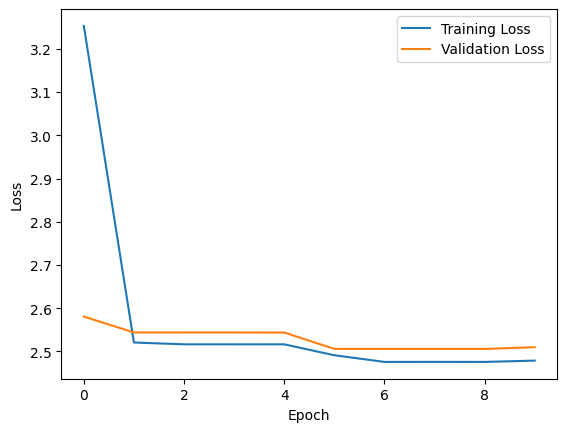

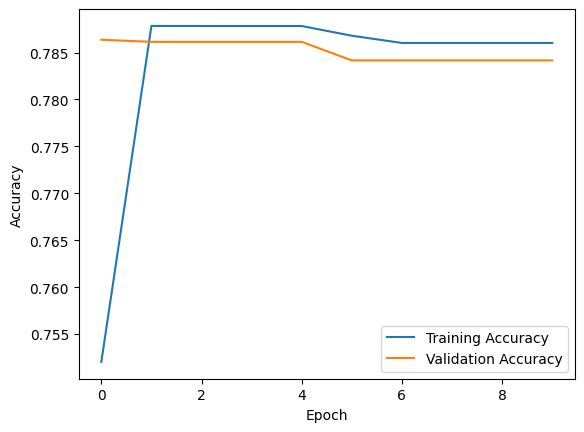

In [47]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Both graphs suggest that the model is fitting well to the training data and generalizing well to the validation data, as indicated by the close alignment of the training and validation lines.